# Buy and hold unhedged strategy

/Users/anejrozman/Documents/mscqf/mlffacs2/MLFCS/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CEX shape & span : (17396, 1) 2025-03-04 15:38:00 → 2025-03-16 17:51:00
DEX shape & span : (109025, 1) 2025-03-04 15:37:11 → 2025-03-16 17:50:59


simulating episode: 100%|██████████| 1000/1000 [02:31<00:00,  6.59step/s]


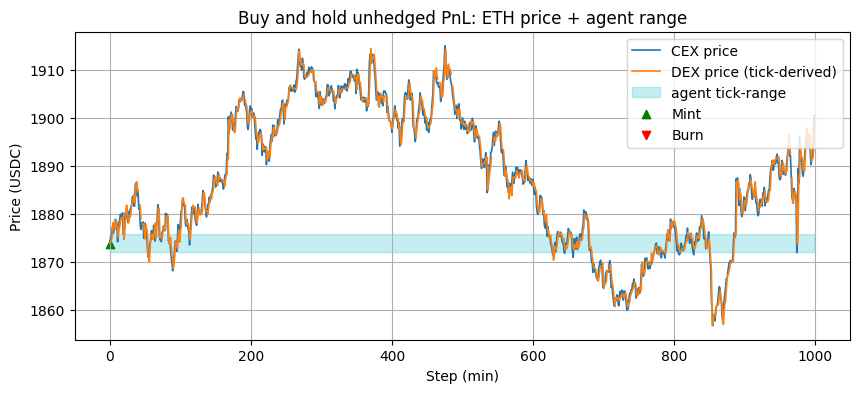

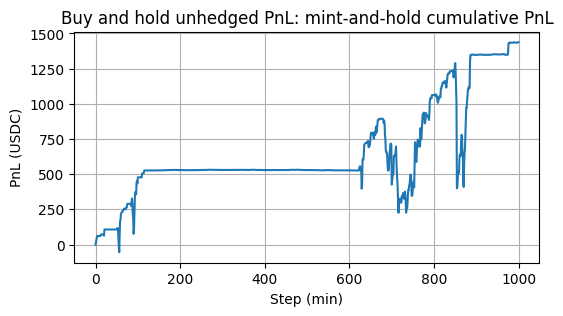

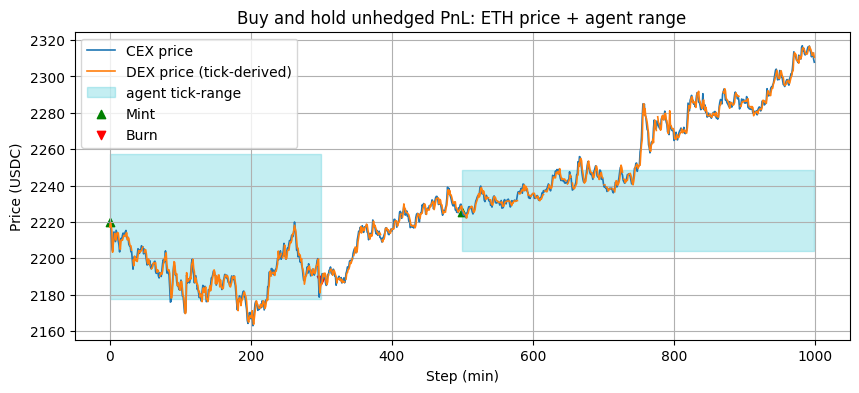

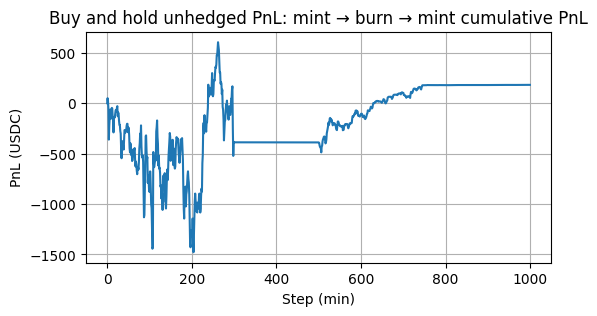

In [1]:
from tqdm.auto import tqdm     
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from env_unhedged_agent import UniswapV3LPGymEnv
from config.env_config import Config

np.random.seed(43)

def tick_to_price(tick: int) -> float:
    return 1e12 / (1.0001 ** (tick / 2)) ** 2

def get_dex_price(env, ts):
    """Convert pool tick at *ts* into a USDC-per-ETH price (forward-fill)."""
    if ts in env.lp_span.index:
        tick = env.lp_span.loc[ts, "tick"]
        if isinstance(tick, pd.Series):
            tick = tick.mean()
    else:                                
        pos = env.lp_span.index.searchsorted(ts, side="right") - 1
        tick = env.lp_span.iloc[pos]["tick"]
        if isinstance(tick, pd.Series):
            tick = tick.mean()
    return tick_to_price(float(tick))


def run_scenario_with_band(env, action_fn, show_progress: bool = True):
    obs, _ = env.reset()
    cex_px, dex_px, pnl = [], [], []
    plow, phigh = [], []
    mints_x, mints_y, burns_x, burns_y = [], [], [], []

    done, step = False, 0
    iterator = tqdm(total=env.EPISODE_LEN, desc="simulating episode",
                    disable=not show_progress, unit="step")

    while not done:
        ts = env.decision_grid[env.idx]
        cex_px.append(env._eth_price(ts))
        dex_px.append(get_dex_price(env, ts))

        pre_active = env.active
        action = action_fn(step)
        obs, reward, done, *_ = env.step(action)
        post_active = env.active
        pnl.append(env.cumulative_pnl)

        if post_active:
            plow.append(tick_to_price(env.tick_l))
            phigh.append(tick_to_price(env.tick_u))
        else:
            plow.append(np.nan)
            phigh.append(np.nan)

        if (pre_active is False) and (post_active is True):
            mints_x.append(step)
            mints_y.append(cex_px[-1])
        elif (pre_active is True) and (post_active is False):
            burns_x.append(step)
            burns_y.append(cex_px[-1])

        step += 1
        iterator.update(1)

    iterator.close()
    t_arr = np.arange(step)
    return (t_arr, np.array(cex_px), np.array(dex_px), np.array(pnl),
            np.array(plow), np.array(phigh),
            np.array(mints_x), np.array(mints_y),
            np.array(burns_x), np.array(burns_y))


def run_scenario(env, action_fn, show_progress: bool = True):
    (t, cex_px, dex_px, pnl, *_extras) = run_scenario_with_band(
        env, action_fn, show_progress)
    return t, cex_px, dex_px, pnl


env_cfg = Config()
base_env = UniswapV3LPGymEnv(env_cfg, feat_num=12)
base_env.EPISODE_LEN = 1_000

print("CEX shape & span :", base_env.eth_px.shape, 
      base_env.eth_px.index.min(), "→", base_env.eth_px.index.max())
print("DEX shape & span :", base_env.lp_span.shape, 
      base_env.lp_span.index.min(), "→", base_env.lp_span.index.max())

def s1_action(step):
    """Mint at t=0 and keep the position live."""
    return np.array([1.0, np.random.randint(1, 3)], dtype=np.float32)  

(t1, cex1, dex1, pnl1,
 plow1, phigh1,
 mints1_x, mints1_y,
 burns1_x, burns1_y) = run_scenario_with_band(base_env, s1_action)

env2 = UniswapV3LPGymEnv(env_cfg, feat_num=12)
env2.EPISODE_LEN = 1_000

def s2_action(step):
    """Mint (0-299), burn (300-499), mint again (500-999)."""
    if step in (0, 500):
        return np.array([1.0, np.random.randint(10, 20)], dtype=np.float32)  
    if 0 < step < 300 or step >= 500:
        return np.array([1.0, np.random.randint(2, 4)], dtype=np.float32)  
    return np.array([0.0, 0.0], dtype=np.float32)       

(t2, cex2, dex2, pnl2,
 plow2, phigh2,
 mints2_x, mints2_y,
 burns2_x, burns2_y) = run_scenario_with_band(env2, s2_action)


plt.figure(figsize=(10,4))
plt.plot(t1, cex1, label="CEX price", linewidth=1.2)
plt.plot(t1, dex1, label="DEX price (tick-derived)", linewidth=1.2)
plt.fill_between(t1, plow1, phigh1, color="tab:cyan", alpha=0.25,
                 label="agent tick-range")
plt.scatter(mints1_x, mints1_y, marker="^", color="green", label="Mint")
plt.scatter(burns1_x, burns1_y, marker="v", color="red", label="Burn")
plt.xlabel("Step (min)")
plt.ylabel("Price (USDC)")
plt.title("Buy and hold unhedged PnL: ETH price + agent range")
plt.legend()
plt.grid(True)


plt.figure(figsize=(6,3))
plt.plot(t1, pnl1)
plt.xlabel("Step (min)")
plt.ylabel("PnL (USDC)")
plt.title("Buy and hold unhedged PnL: mint-and-hold cumulative PnL")
plt.grid(True)

plt.figure(figsize=(10,4))
plt.plot(t2, cex2, label="CEX price", linewidth=1.2)
plt.plot(t2, dex2, label="DEX price (tick-derived)", linewidth=1.2)
plt.fill_between(t2, plow2, phigh2, color="tab:cyan", alpha=0.25,
                 label="agent tick-range")
plt.scatter(mints2_x, mints2_y, marker="^", color="green", label="Mint")
plt.scatter(burns2_x, burns2_y, marker="v", color="red", label="Burn")
plt.xlabel("Step (min)")
plt.ylabel("Price (USDC)")
plt.title("Buy and hold unhedged PnL: ETH price + agent range")
plt.legend()
plt.grid(True)
plt.savefig("images/buy_and_hold_unhedged_price_chart.png", dpi=300, bbox_inches='tight')

plt.figure(figsize=(6,3))
plt.plot(t2, pnl2)
plt.xlabel("Step (min)")
plt.ylabel("PnL (USDC)")
plt.title("Buy and hold unhedged PnL: mint → burn → mint cumulative PnL")
plt.grid(True)
plt.savefig("images/buy_and_hold_unhedged_pnl.png", dpi=300, bbox_inches='tight')

plt.show()